In [1]:
import jax

jax.config.update("jax_enable_x64", True)
from torch.utils.data import DataLoader, Subset
import optax
import jax.numpy as jnp

from specq_jax.core import (
    SpecQDataset,
    create_train_step,
    loss as loss_fn,
    gate_loss,
    X,
    Y,
    Z,
    calculate_expvals,
    plot_expvals,
    gate_fidelity,
    Wo_2_level,
    rotating_transmon_hamiltonian,
)
from specq_jax.data import load_data

from specq_jax.model import BasicBlackBox
from exp_data_0020 import get_multi_drag_pulse_sequence
import specq_dev.specq.shared as specq

from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box
import pandas as pd
import matplotlib.pyplot as plt
from alive_progress import alive_bar, alive_it

from torch import Generator

In [2]:
def with_validation_train(
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    train_step,
    test_step,
    model_params,
    opt_state,
    num_epochs=1250,
):

    history = []
    total_len = len(train_dataloader)

    NUM_EPOCHS = num_epochs

    with alive_bar(int(NUM_EPOCHS * total_len), force_tty=True) as bar:
        for epoch in range(NUM_EPOCHS):
            total_loss = 0.0
            for i, batch in enumerate(train_dataloader):

                _pulse_parameters = batch["x0"].numpy()
                _unitaries = batch["x1"].numpy()
                _expectations = batch["y"].numpy()

                model_params, opt_state, loss = train_step(
                    model_params, opt_state, _pulse_parameters, _unitaries, _expectations
                )

                history.append(
                    {
                        "epoch": epoch,
                        "step": i,
                        "loss": float(loss),
                        "global_step": epoch * total_len + i,
                        "val_loss": None,
                    }
                )

                total_loss += loss

                bar()

            # Validation
            val_loss = 0.0
            for i, batch in enumerate(val_dataloader):

                _pulse_parameters = batch["x0"].numpy()
                _unitaries = batch["x1"].numpy()
                _expectations = batch["y"].numpy()

                val_loss += test_step(model_params, _pulse_parameters, _unitaries, _expectations)

            history[-1]["val_loss"] = float(val_loss / len(val_dataloader))


    return model_params, opt_state, history

def plot_history(history: list):

    hist_df = pd.DataFrame(history)
    train = hist_df[["global_step", "loss"]].values

    train_x = train[:, 0]
    train_y = train[:, 1]

    validate = hist_df[["global_step", "val_loss"]].replace(0, jnp.nan).dropna().values

    validate_x = validate[:, 0]
    validate_y = validate[:, 1]
    # The second plot has height ratio 2
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

    # The first plot is the training loss and the validation loss
    ax.plot(train_x, train_y, label="train_loss")
    ax.plot(validate_x, validate_y, label="val_loss")
    ax.set_yscale("log")

    # plot the horizontal line [1e-3, 1e-2]
    ax.axhline(1e-3, color="red", linestyle="--")
    ax.axhline(1e-2, color="red", linestyle="--")

    ax.legend()

    fig.tight_layout()

    return fig, ax
    
def optimize(
    x0,
    lower,
    upper,
    fun
):

    pg = ProjectedGradient(fun=fun, projection=projection_box)
    opt_params, state = pg.run(
        jnp.array(x0),
        hyperparams_proj=(lower, upper)
    )

    return opt_params, state

In [3]:
exp_data, pulse_parameters, unitaries, expectations, pulse_sequence, simulator = (
    load_data(
        "../../specq-experiment/datasets/0020",
        get_multi_drag_pulse_sequence,
        rotating_transmon_hamiltonian,
    )
)

In [5]:
start_idx, end_idx = 0, 1500
batch_size = 150
MASTER_KEY_SEED = 0
g = Generator()
g.manual_seed(MASTER_KEY_SEED)

master_key = jax.random.PRNGKey(MASTER_KEY_SEED)
random_split_key, model_key, gate_optim_key = jax.random.split(master_key, 3)

# Final goal of setting up is to create a dataset and a dataloader
dataset = SpecQDataset(
    pulse_parameters=pulse_parameters[start_idx: end_idx],
    unitaries=unitaries[start_idx: end_idx],
    expectation_values=expectations[start_idx: end_idx],
)

# Randomly split dataset into training and validation
val_indices = jax.random.choice(
    random_split_key, len(dataset), (int(0.2 * len(dataset)),), replace=False
).tolist()

training_indices = list(
    set([i for i in range(len(dataset))]) - set(val_indices)
)

train_dataset = Subset(dataset, training_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=g)

model = BasicBlackBox(feature_size=5)

warmup_start_lr, warmup_steps = 1e-6, 1000
start_lr, end_lr, steps = 1e-2, 1e-5, 10_000
lr_scheduler = optax.join_schedules(
    [
        optax.linear_schedule(
            warmup_start_lr,
            start_lr,
            warmup_steps,
        ),
        optax.linear_schedule(
            start_lr,
            end_lr,
            steps - warmup_steps,
        ),
    ],
    [warmup_steps],
)

optimiser = optax.adam(lr_scheduler)

train_step, test_step, model_params, opt_state = create_train_step(
    key=model_key,
    model=model,
    optimiser=optimiser,
    loss_fn=lambda params, pulse_parameters, unitaries, expectations: loss_fn(
        params, pulse_parameters, unitaries, expectations, model
    ),
    input_shape=(batch_size, pulse_parameters.shape[1]),
)

In [6]:
print(model.tabulate(jax.random.key(0), jnp.ones((batch_size, pulse_parameters.shape[1]))))


                             BasicBlackBox Summary                              
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path     ┃ module        ┃ inputs         ┃ outputs         ┃ params         ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│          │ BasicBlackBox │ float64[150,3… │ X:              │                │
│          │               │                │   D:            │                │
│          │               │                │ float64[150,2]  │                │
│          │               │                │   U:            │                │
│          │               │                │ float64[150,3]  │                │
│          │               │                │ Y:              │                │
│          │               │                │   D:            │                │
│          │               │                │ float64[150,2]  │                │
│          │               

In [7]:
model_params, opt_state, history = with_validation_train(
    train_dataloader,
    val_dataloader,
    train_step,
    test_step,
    model_params,
    opt_state,
)

|                                        | ▁▃▅ 0/10000 [0%] in 0s (~0s, 0.0/s) 

on 0: /Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
        x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


|████████████████████████████████████████| 10000/10000 [100%] in 30.4s (329.66/s


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

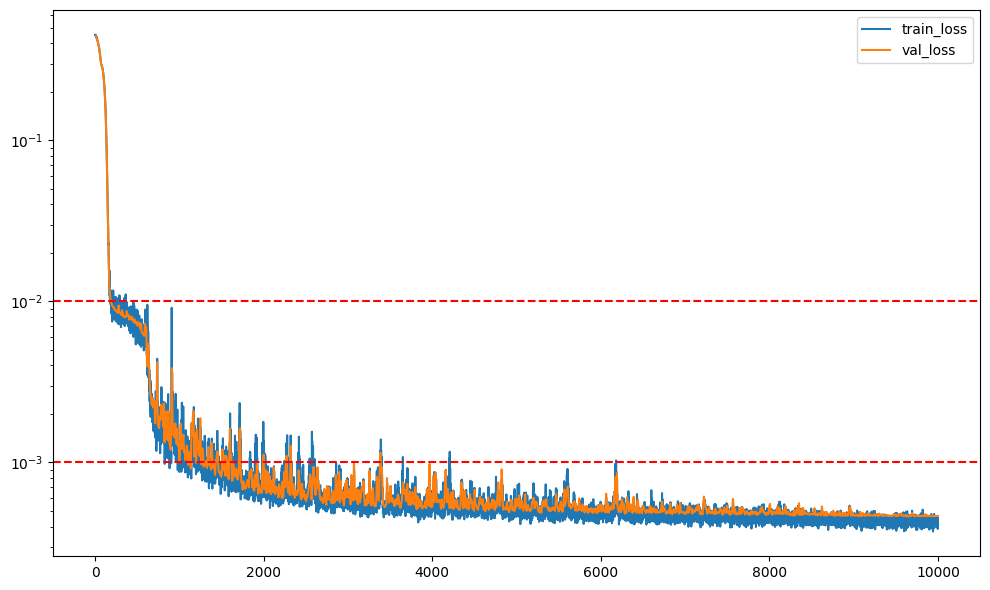

In [8]:
plot_history(history)

## Model saving

What to save:
- Model architecture (how to initialize model) -> Model Config (JSON)
- History (training history) -> History (csv)
- [Optional] Optimizer state (how to initialize optimizer) -> Optimizer Config (JSON)

In [43]:
from dataclasses import dataclass, asdict
import os
import datetime
import json
from typing import Union, Callable

def generate_path_with_datetime(sub_dir: str = None):
    return os.path.join(
        sub_dir if sub_dir is not None else "",
        datetime.datetime.now().strftime("Y%YM%mD%d-H%HM%MS%S")
    )

@dataclass
class DataConfig:
    EXPERIMENT_IDENTIFIER: str
    hamiltonian: str
    pulse_sequence: dict

    def to_file(self, path: str):
        os.makedirs(path, exist_ok=True)
        with open(f"{path}/data_config.json", "w") as f:
            json.dump(self.to_dict(), f, indent=4)

    def to_dict(self):
        return asdict(self)

    @classmethod
    def from_dict(cls, data: dict):
        return cls(**data)

    @classmethod
    def from_file(cls, path: str):
        with open(f"{path}/data_config.json", "r") as f:
            config_dict = json.load(f)
        return cls.from_dict(config_dict)
        
@dataclass
class ModelState:
    model_config: dict
    model_params: dict

    def save(self, path: str):
        # turn the dataclass into a dictionary
        model_params = jax.tree.map(lambda x: x.tolist(), self.model_params)

        os.makedirs(path, exist_ok=True)

        with open(f"{path}/model_config.json", "w") as f:
            json.dump(self.model_config, f, indent=4)

        with open(f"{path}/model_params.json", "w") as f:
            json.dump(model_params, f, indent=4)

    @classmethod
    def load(cls, path: str):
        with open(f"{path}/model_config.json", "r") as f:
            model_config = json.load(f)

        with open(f"{path}/model_params.json", "r") as f:
            model_params = json.load(f)

        # Define is_leaf function to check if a node is a leaf
        # If the node is a leaf, convert it to a jnp.array
        # The function will check if object is list, if list then convert to jnp.array
        def is_leaf(x):
            return isinstance(x, list)

        # Apply the inverse of the tree.map function
        model_params = jax.tree.map(lambda x: jnp.array(x), model_params, is_leaf=is_leaf)

        return cls(model_config, model_params)


def save_model(
    path: str,
    experiment_identifier: str,
    pulse_sequence: specq.BasePulseSequence,
    hamiltonian: Union[str, Callable],
    model_config: dict,
    model_params: dict,
    history: list,
    with_auto_datetime: bool = True,
):

    _path = generate_path_with_datetime(path) if with_auto_datetime else path

    os.makedirs(_path, exist_ok=True)

    model_state = ModelState(
        model_config=model_config,
        model_params=model_params,
    )

    model_state.save(_path + "/model_state")

    # Save the history
    hist_df = pd.DataFrame(history)
    hist_df.to_csv(_path + "/history.csv", index=False)

    # Save the data config
    data_config = DataConfig(
        EXPERIMENT_IDENTIFIER=experiment_identifier,
        hamiltonian=hamiltonian if isinstance(hamiltonian, str) else hamiltonian.__name__,
        pulse_sequence=pulse_sequence.to_dict(),
    )

    data_config.to_file(_path)

    return _path

def load_model(path: str):
    model_state = ModelState.load(path + "/model_state")
    hist_df = pd.read_csv(path + "/history.csv")
    data_config = DataConfig.from_file(path)

    return (
        model_state,
        hist_df.to_dict(orient="records"),
        data_config,
    )

In [44]:
PATH = "models/0020"

_path = save_model(
    PATH,
    "0020",
    pulse_sequence,
    rotating_transmon_hamiltonian,
    asdict(model),
    model_params,
    history,
    with_auto_datetime=False,
)

model_state, restored_history, data_config = load_model(_path)

In [45]:
model_state.model_params

{'params': {'Dense_0': {'bias': Array([ 0.4218311 , -0.03492433,  0.88155353,  0.        , -0.06492988],      dtype=float64),
   'kernel': Array([[-3.86969656e-01, -3.85368049e-01, -2.07819319e+00,
            2.39153028e-01,  1.38035879e-01],
          [-6.47626147e-02, -2.64262240e-02,  5.22428825e-02,
           -2.69164801e-01,  2.62480795e-01],
          [-1.16606645e-01, -1.41758189e-01,  5.61754741e-02,
           -2.27472708e-01,  2.78607607e-01],
          [ 4.17497814e-01,  7.19520748e-02,  3.59100010e-03,
            1.35539174e-02,  2.88905144e-01],
          [ 2.59774793e-02, -2.31217239e-02,  3.66339982e-02,
            1.83454826e-02,  9.05345902e-02],
          [ 1.27006846e-03,  1.22669891e-01, -6.21501094e-05,
           -3.26380320e-02,  5.84257720e-03],
          [ 3.65392804e-01,  2.06322998e-01,  2.60997042e-02,
            1.72010422e-01,  3.85610878e-01],
          [ 3.93572487e-02, -1.06051631e-01,  3.90878804e-02,
           -5.76102734e-02,  1.02056399e-01],


## Gate optimization

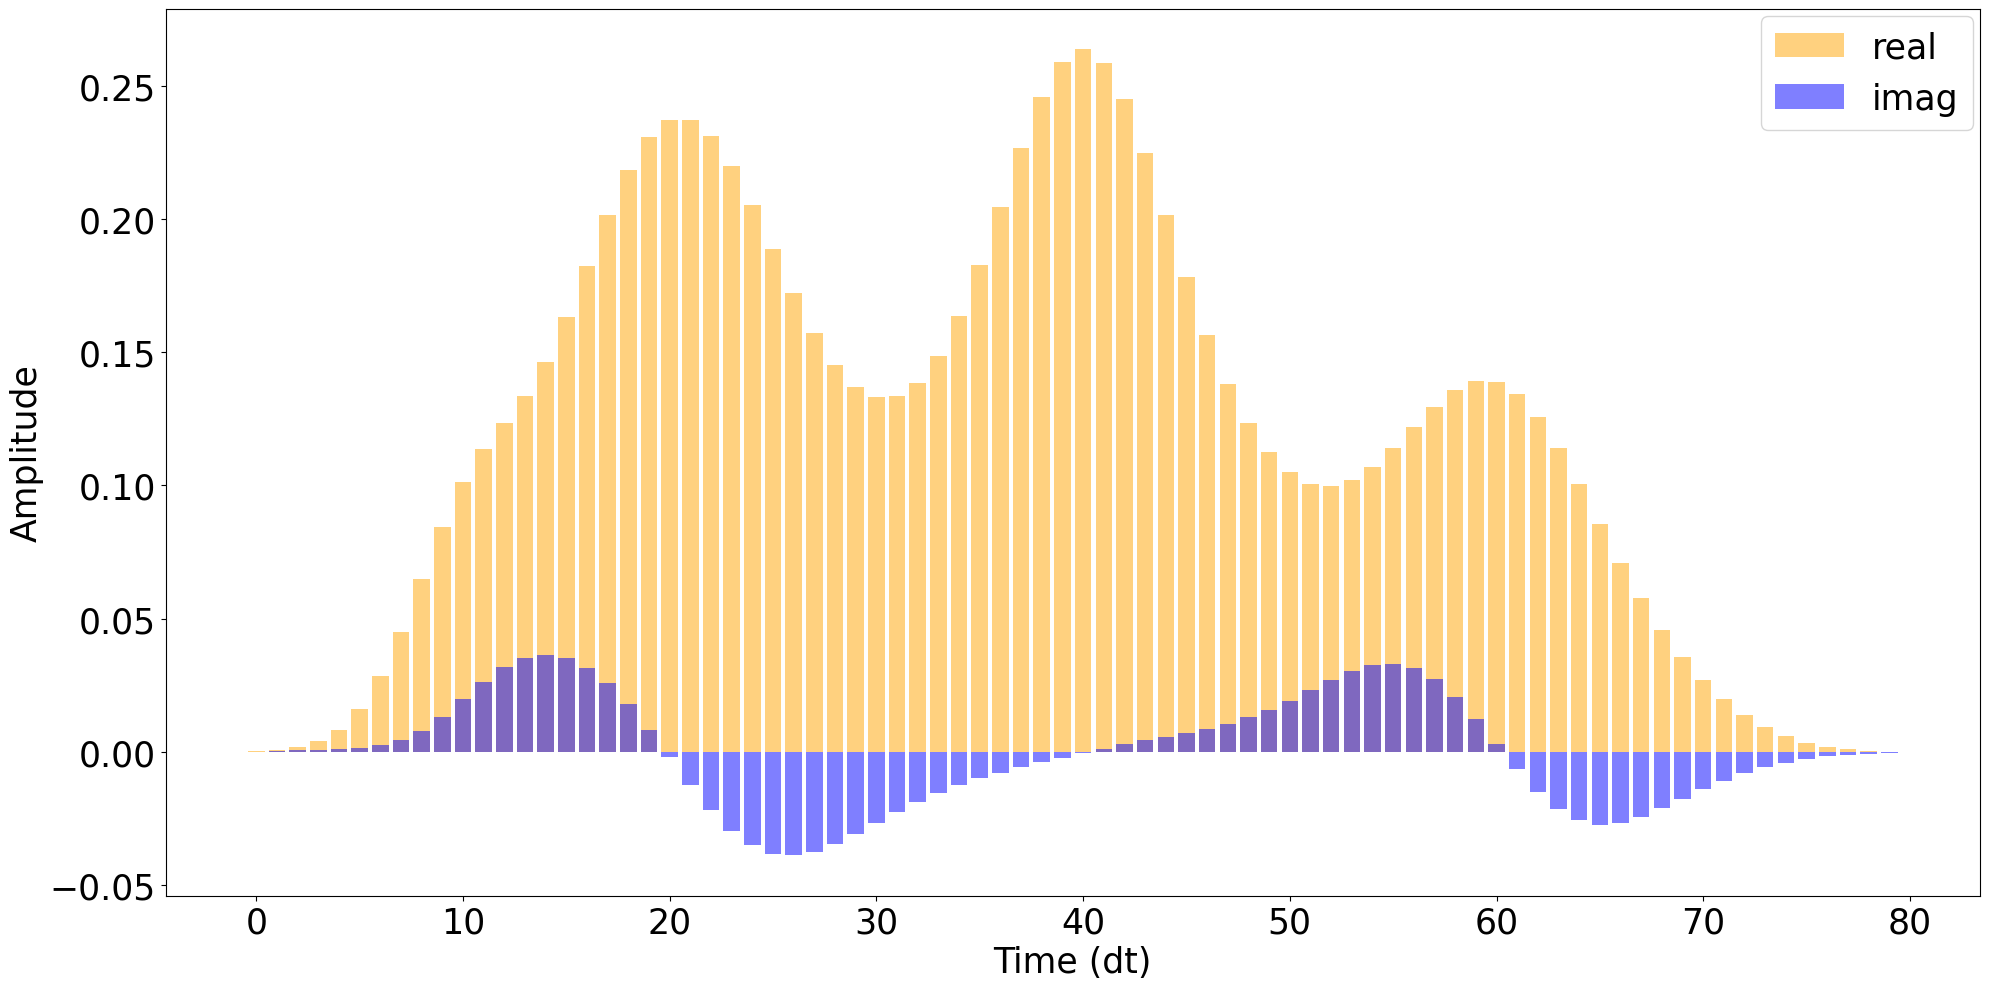

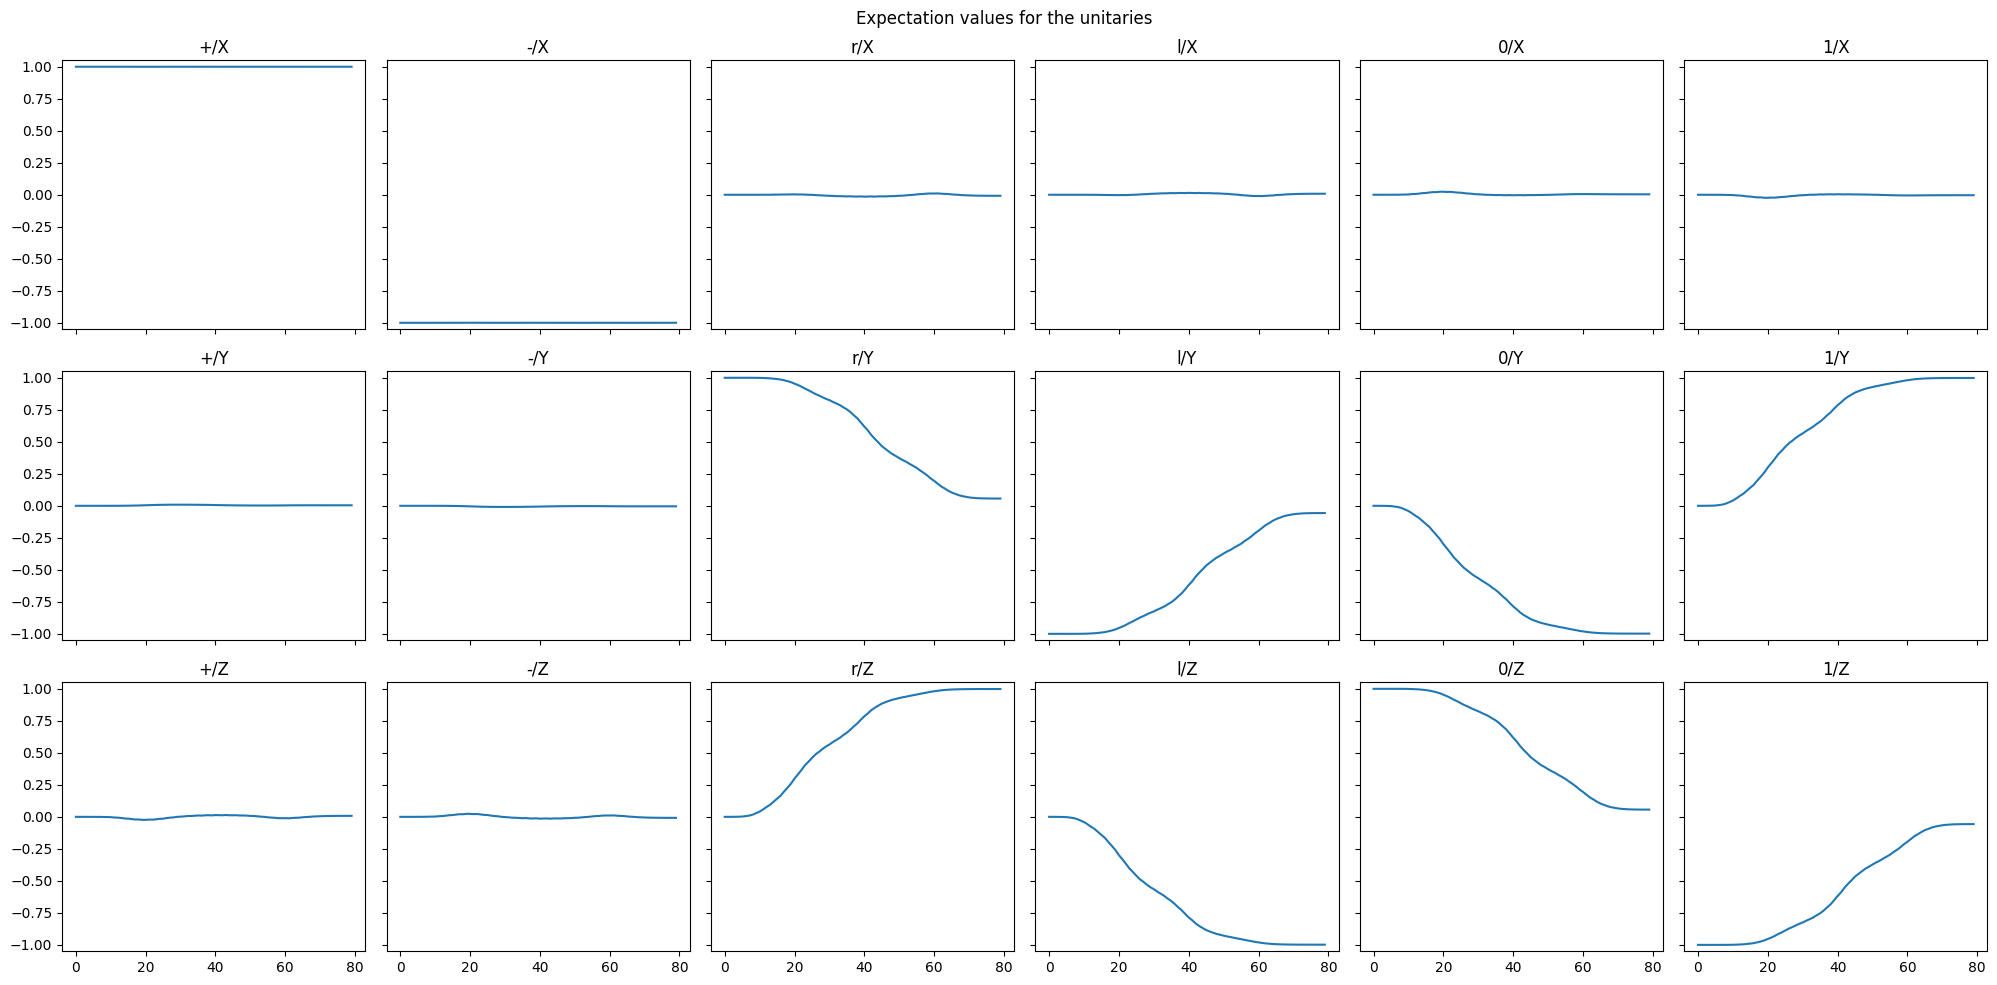

In [46]:
target_unitary = jax.scipy.linalg.sqrtm(X)
fun = lambda x: gate_loss(
    x,
    BasicBlackBox(**model_state.model_config),
    model_state.model_params,
    simulator,
    pulse_sequence,
    target_unitary,
)

lower, upper = pulse_sequence.get_bounds()
lower = pulse_sequence.list_of_params_to_array(lower)
upper = pulse_sequence.list_of_params_to_array(upper)

pulse_params = pulse_sequence.sample_params(gate_optim_key)
x0 = pulse_sequence.list_of_params_to_array(pulse_params)

opt_params, state = optimize(x0, lower, upper, fun)

# Plot the optmized result
opt_pulse_params = pulse_sequence.array_to_list_of_params(opt_params)
pulse_sequence.draw(opt_pulse_params)

# Calculate the expectation values
waveforms = pulse_sequence.get_waveform(opt_pulse_params)
unitaries_opt = simulator(waveforms)

expvals = calculate_expvals(unitaries_opt)
plot_expvals(expvals)

In [48]:
Wo_params = model.apply(model_params, jnp.expand_dims(opt_params, axis=0))
Wo_params = jax.tree.map(lambda x: jnp.squeeze(x, 0), Wo_params)

fidelities = {}
for pauli_str, pauli_op in zip(["X", "Y", "Z"], [X, Y, Z]):
    Wo = Wo_2_level(U=Wo_params[pauli_str]["U"], D=Wo_params[pauli_str]["D"])
    # evaluate the fidleity to the Pauli operator
    fidelities[pauli_str] = gate_fidelity(Wo, pauli_op)

fidelities, gate_fidelity(unitaries_opt[-1], target_unitary)

({'X': Array(0.99785112, dtype=float64),
  'Y': Array(0.99604939, dtype=float64),
  'Z': Array(0.99926673, dtype=float64)},
 Array(0.99917399, dtype=float64))

## Visualization

In [ ]:
import qutip as qt

# A function of signature eval_params(params: jnp.ndarray) -> dict[str, float]
def eval_params(
        pulse_params,
        model,
        model_params,
    ):
    _Wo_params = model.apply(model_params, jnp.expand_dims(pulse_params, axis=0))
    Wo_params = jax.tree_map(lambda x: jnp.squeeze(x, 0), _Wo_params)

    fidelities = {}
    for pauli_str, pauli_op in zip(["X", "Y", "Z"], [X, Y, Z]):
        Wo = Wo_2_level(U=Wo_params[pauli_str]["U"], D=Wo_params[pauli_str]["D"])
        # evaluate the fidleity to the Pauli operator
        fidelities[pauli_str] = gate_fidelity(Wo, pauli_op)

    return fidelities

expvals_dict = {}
for idx, exp in enumerate(specq.default_expectation_values):

    if exp.initial_state not in expvals_dict:
        expvals_dict[exp.initial_state] = {}

    expvals_dict[exp.initial_state][exp.observable] = expvals[idx]

b = qt.Bloch()
b.make_sphere()
for initial_state in expvals_dict.keys():
    b.add_points(
        [
            expvals_dict[initial_state]["X"],
            expvals_dict[initial_state]["Y"],
            expvals_dict[initial_state]["Z"],
        ]
    )

b.render()
b.show()